In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow import keras


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dict = unpickle("C:\\Users\\Samuel\\Downloads\\cifar-10-batches-py\\data_batch_1")

In [2]:
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical   


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

plt.imshow(train_x_orig[7])
print(classes[np.squeeze(train_y[:,7])].decode('utf-8'))

m_train = train_y.shape[1]
m_test = test_y.shape[1]
num_px = train_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

In [4]:
train_x_flatten = X_train.reshape(X_train.shape[0], -1).T
test_x_flatten = X_test.reshape(X_test.shape[0], -1).T
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print ("train_x_flatten shape: " + str(train_x.shape))

print ("test_x_flatten shape: " + str(test_x.shape))

print ("sanity check after reshaping: " + str(train_x[0:5,0]))

train_x_flatten shape: (3072, 50000)
test_x_flatten shape: (3072, 10000)
sanity check after reshaping: [0.23137255 0.24313725 0.24705882 0.16862745 0.18039216]


In [5]:
train_y=np.zeros((10,50000))
test_y=np.zeros((10,10000))

for i in range(50000):
    train_y[y_train[i],i]=1
for i in range(10000):
    test_y[y_test[i],i]=1
    
print ("train_y shape: " + str(train_y.shape))
print ("test_y shape: " + str(test_y.shape))
print ("sanity check after reshaping: " + str(train_y[0:5]))

train_y shape: (10, 50000)
test_y shape: (10, 10000)
sanity check after reshaping: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def arctan(Z):
    A = np.arctan(Z)
    cache = Z
    return A, cache

def arctan_backward(dA, cache):
    Z = cache
    dZ = dA / (Z*Z+1)
    
    return dZ
    
def softplus(Z):
    A = np.log(1+np.exp(Z))
    cache = Z
    return A, cache

def softplus_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s
    
    return dZ

In [57]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":        
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "arctan":
        A, activation_cache = arctan(Z)
    elif activation == "softplus":
        A, activation_cache = softplus(Z)    
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def forward(X, parameters, activation):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    activation -- activation function
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation)
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation)
    caches.append(cache)
    
            
    return AL, caches



def compute_cost(AL, Y,fcn):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    
    m = Y.shape[1]
    n = Y.shape[0]
    epsilon = 1e-6
    
    if fcn=="logistic":
        cost = (1./(m*n)) * np.sum((Y*np.log(AL+epsilon)) - ((1-Y)*np.log(1-AL+epsilon)))
    
        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        assert(cost.shape == ())
    
        return cost
    elif fcn == "l2":
        
        # Compute loss from aL and y.
        cost = (1./(2*m)) * (np.dot(AL-Y,(AL-Y).T))

        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        assert(cost.shape == ())

        return cost
    elif fcn == "CE":
        log_likelihood = -Y.T*np.log(AL.T+epsilon)
        cost = np.sum(log_likelihood) / m

        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        assert(cost.shape == ())

        return cost
        

def d_cost(AL,Y,fcn):
    epsilon = 1e-6
    if fcn=="l2":
        return AL-Y
    elif fcn == "logistic":
        return - (np.divide(Y, AL+epsilon) - np.divide(1 - Y, (1 - AL)+epsilon))
    elif fcn == "CE":
        return - (np.divide(Y,AL+epsilon))
    
    

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "arctan":   
        dZ = arctan_backward(dA, activation_cache)
    elif activation == "softplus":   
        dZ = softplus_backward(dA, activation_cache)    
        
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


def backward(AL, Y,activation, caches, loss):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    
    dAL = d_cost(AL,Y,loss)
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = activation_backward(dAL, current_cache, activation)
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l + 2)], current_cache, activation)
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [8]:
def predict(X, y, parameters, activation = "sigmoid"):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((y.shape[0],y.shape[1]))
    
    # Forward propagation
    probas, caches = forward(X, parameters, activation)
    
    
    # convert probas to 0/1 predictions
#    for i in range(0, probas.shape[1]):
#        j = np.argmax(probas[:,i])
#        p[j,i]= 1
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
#    print("Accuracy: "  + str(np.sum((p == y)/m)))

#    print(p[:,0:10])
#    print(probas[:,0:10])
#    print(y[:,0:10])

    p_single = np.zeros((1,m))
    y_single = np.zeros((1,m))
    
    for i in range(m):
        p_single[0,i]=np.argmax(probas[:,i])
        y_single[0,i]=np.argmax(y[:,i])                
            
        
    return np.sum((p_single == y_single)/m)

    

In [46]:
def Neural_Network(X_in, Y_in, layers_dims, activation = "sigmoid", learning_rate = 0.0075, num_iterations = 3000, print_cost=False, print_acc=False, loss="l2"):#lr was 0.009

    validation_cut=round((X_in.shape[1])*.9)
    X=X_in[:,0:validation_cut]
    Y=Y_in[:,0:validation_cut]
    X_valid=X_in[:,validation_cut:X_in.shape[1]]
    Y_valid=Y_in[:,validation_cut:Y_in.shape[1]]
    np.random.seed(1)
    costs = []    # keep track of cost
    accs   = []
    
    parameters = initialize_parameters(layers_dims)
     
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = forward(X, parameters, activation)
        
        # Backward propagation
        grads = backward(AL, Y,activation, caches, loss)
 
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            cost = compute_cost(AL, Y,loss)
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
       
        # Print the accuracy every 100 training example
        if print_acc and i % 100 == 0:
            acc = predict(X_valid,Y_valid,parameters,activation)
            print ("Accuracy after iteration %i: %f" %(i, acc))
            accs.append(acc)
            
    # plot the cost
    if print_cost:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
    # plot the Accuracy
    if print_acc:
        plt.plot(np.squeeze(accs))
        plt.ylabel('Accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

Accuracy after iteration 0: 0.060000
Accuracy after iteration 100: 0.160000
Accuracy after iteration 200: 0.190000
Accuracy after iteration 300: 0.200000
Accuracy after iteration 400: 0.190000
Accuracy after iteration 500: 0.180000
Accuracy after iteration 600: 0.200000
Accuracy after iteration 700: 0.210000
Accuracy after iteration 800: 0.230000
Accuracy after iteration 900: 0.230000
Accuracy after iteration 1000: 0.230000
Accuracy after iteration 1100: 0.250000
Accuracy after iteration 1200: 0.260000
Accuracy after iteration 1300: 0.260000
Accuracy after iteration 1400: 0.260000
Accuracy after iteration 1500: 0.280000
Accuracy after iteration 1600: 0.280000
Accuracy after iteration 1700: 0.280000
Accuracy after iteration 1800: 0.280000
Accuracy after iteration 1900: 0.290000
Accuracy after iteration 2000: 0.290000
Accuracy after iteration 2100: 0.290000
Accuracy after iteration 2200: 0.300000
Accuracy after iteration 2300: 0.300000
Accuracy after iteration 2400: 0.310000
Accuracy aft

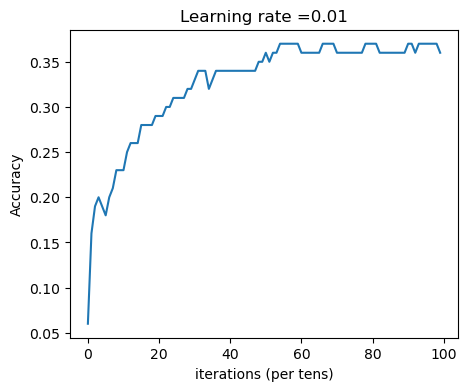

In [13]:
layers_dims = [3072, 100, 10]
parameters1 = Neural_Network(train_x[:,0:1000], train_y[:,0:1000], layers_dims, activation = "sigmoid",learning_rate = 0.01, num_iterations = 10000, print_acc = True, loss=logistic)

Accuracy after iteration 0: 0.103000
Accuracy after iteration 100: 0.269000
Accuracy after iteration 200: 0.322000
Accuracy after iteration 300: 0.343000
Accuracy after iteration 400: 0.356000
Accuracy after iteration 500: 0.364000
Accuracy after iteration 600: 0.372000
Accuracy after iteration 700: 0.370000
Accuracy after iteration 800: 0.369000
Accuracy after iteration 900: 0.373000


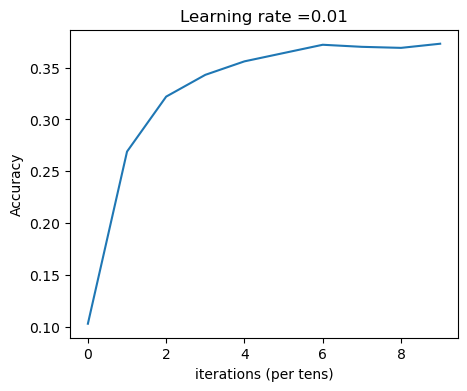

In [20]:
layers_dims = [3072, 768,384,128, 10]
parameters2 = Neural_Network(train_x[:,0:10000], train_y[:,0:10000], layers_dims, activation = "relu",learning_rate = 0.01, num_iterations = 1000, print_acc = True)

In [58]:
layers_dims = [3072, 768,384,128, 10]
parameters3 = Neural_Network(train_x[:,0:10000], train_y[:,0:10000], layers_dims, activation = "relu",learning_rate = 0.01, num_iterations = 1000, print_acc = True,loss="logistic")

C:\Users\Samuel\AppData\Local\Temp\ipykernel_6736\576495412.py:132: RuntimeWarning: invalid value encountered in subtract
  cost = (1./(m*n)) * np.sum((Y*np.log(AL+epsilon)) - ((1-Y)*np.log(1-AL+epsilon)))


Cost after iteration 0: nan
Accuracy after iteration 0: 0.104000


KeyboardInterrupt: 

In [12]:
predict(train_x[:,0:20000], train_y[:,0:20000], parameters,"sigmoid")

0.32100000000000006

In [129]:
predict(train_x[:,0:5], train_y[:,0:5], parameters,"relu")

0.0

In [93]:
probas=np.array([[0.        , 0. ,        0.17798488, 0. ,        0.119985,   0.
,  0.03483416, 0.    ,     0.3896086 , 0.        ],[0.20768916, 0.49230858, 0.03141697, 0.12113249, 0.05045339, 0.12889448,
  0.0574693,  0.   ,      0.00167007 ,0.        ]])
probas=probas.T
print(probas.shape)
p=np.zeros((10,2))

for i in range(0, probas.shape[1]):
        j = np.argmax(probas[:,i])
        p[j,i]= 1
        
print(p)

(10, 2)
[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]]


In [157]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))



In [195]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

In [73]:
print(train_x.shape)
test=np.sum(2*train_x[:,0:3]-(train_x[:,0:3]+1))
print(test)

(3072, 50000)
-4788.282352941176


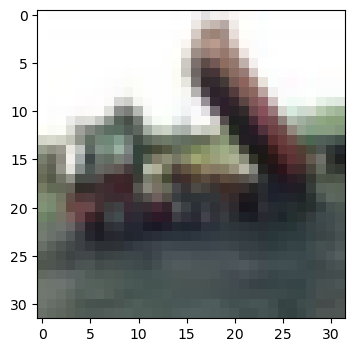

In [66]:
plt.imshow(X_train[2])